In [1]:
# 查看下载视频的信息
def get_video_info(video_path):
    
    # 提取视频信息
    video_info = sv.VideoInfo.from_video_path(video_path)
    
    # 通过将总帧数除以帧率并四舍五入到最近的一秒来计算视频长度
    video_length = timedelta(seconds = round(video_info.total_frames / video_info.fps))
    
    # 打印视频的分辨率、帧率和长度
    print(f"\033[1mVideo Resolution:\033[0m ({video_info.width}, {video_info.height})")
    print(f"\033[1mFPS:\033[0m {video_info.fps}")
    print(f"\033[1mLength:\033[0m {video_length}")

In [2]:
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
from datetime import timedelta
import os

In [3]:
video_path = ('./videos/people-walking.mp4')
get_video_info(video_path)

Video Resolution: (1920, 1080)
FPS: 25
Length: 0:00:14


#### 在视频帧中跟踪对象


0: 384x640 17 persons, 368.8ms
Speed: 5.0ms preprocess, 368.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


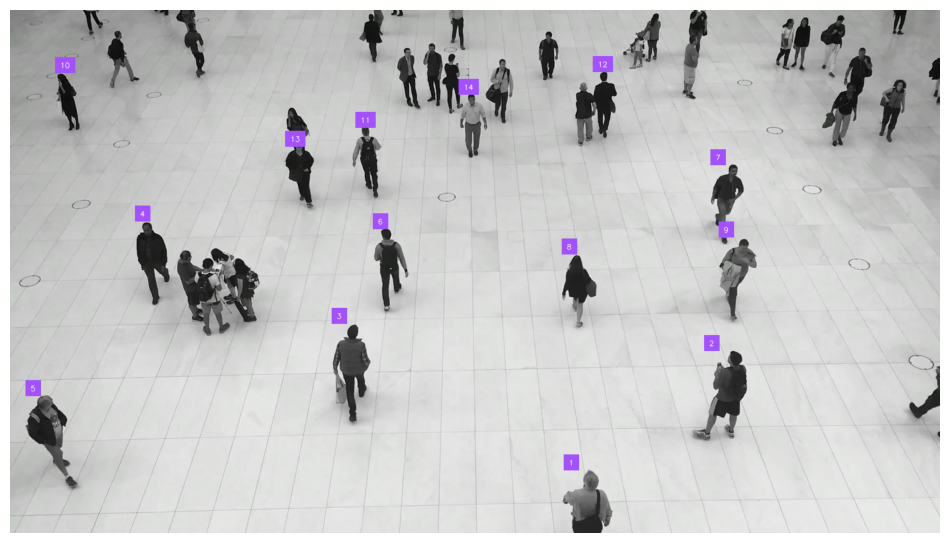

In [4]:
# 加载一个预训练的yolo11 nano模型。
model = YOLO('./weights/yolo11n.pt')

# 根据视频路径创建一个视频信息对象。
video_info = sv.VideoInfo.from_video_path(video_path)

# 创建一个标签标注器，用于为检测结果标注追踪器ID。
label = sv.LabelAnnotator()

# 创建一个ByteTrack对象来追踪检测结果
byte_tracker = sv.ByteTrack(frame_rate=video_info.fps)

# 从视频路径创建一个帧生成器，用于迭代帧
frame_generator = sv.get_video_frames_generator(video_path)

# 从帧生成器中获取一帧
frame = next(frame_generator)

# 将帧传递给模型以运行推理
result = model(frame)[0]

# 将模型结果转换为supervision检测对象
detections = sv.Detections.from_ultralytics(result)

# 使用byte_tracker更新检测结果，并添加追踪器ID
tracked_detections = byte_tracker.update_with_detections(detections)

# 为标签标注器创建带有追踪器ID的标签
labels = [f"{tracker_id}" for tracker_id in tracked_detections.tracker_id]

# 将标签标注器应用到帧上
annotated_frame = label.annotate(scene=frame.copy(), detections=tracked_detections, labels=labels)

# 显示帧
sv.plot_image(annotated_frame)

#### 在视频中跟踪对象

In [ ]:
from tqdm import tqdm

# 加载一个预训练的yolo11 nano模型。
model = YOLO('./weights/yolo11n.pt')

# 根据视频路径创建一个视频信息对象。
video_info = sv.VideoInfo.from_video_path(video_path)

# 创建一个标签标注器，用于为检测结果标注追踪器ID。
label = sv.LabelAnnotator()

# 创建一个ByteTrack对象来追踪检测结果。
byte_tracker = sv.ByteTrack(frame_rate=video_info.fps)

# 从视频路径创建一个帧生成器，用于迭代帧。
frame_generator = sv.get_video_frames_generator(video_path)

# 创建一个视频接收器上下文管理器，用于保存结果视频。
with sv.VideoSink(target_path="trackObjects_result.mp4", video_info=video_info) as sink:

    # 迭代frame_generator生成的帧。
    for frame in tqdm(frame_generator, total=video_info.total_frames):

        # 将帧传递给模型以运行推理。
        result = model(frame)[0]

        # 将模型结果转换为supervision检测对象。
        detections = sv.Detections.from_ultralytics(result)

        # 使用byte_tracker更新检测结果，并添加追踪器ID。
        tracked_detections = byte_tracker.update_with_detections(detections)

        # 为标签标注器创建带有追踪器ID的标签。
        labels = [f"{tracker_id}" for tracker_id in tracked_detections.tracker_id]

        # 将标签标注器应用到帧上。
        annotated_frame = label.annotate(scene=frame.copy(), detections=tracked_detections, labels=labels)

        # 将标注过的帧保存到输出视频中。
        sink.write_frame(frame=annotated_frame)